## 深層の探検ツアー
東工大 D3 梶山 青春 @ 鼎研究室
<img width='500' src="src/madeinabyss.jpg">

In [44]:
import numpy as np
import numpy.ma as ma

npz = np.load('data/inputdata.npz')
x_train, y_train, x_val, y_val = npz["x_train"], npz["y_train"], npz["x_val"], npz["y_val"]
print(f'x_train: {x_train.shape}',
      f'y_train: {y_train.shape}',
      f'x_val: {x_val.shape}',
      f'y_val: {y_val.shape}'
     )
x_train_masked = ma.masked_where(x_train>9999, x_train)
x_val_masked = ma.masked_where(x_val>9999, x_val)

x_train: (1000, 24, 72, 3) y_train: (1000,) x_val: (100, 24, 72, 3) y_val: (100,)


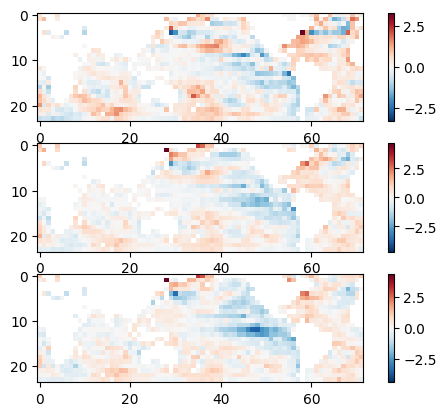

In [45]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig = plt.figure()
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
img1 = ax1.imshow(x_train_masked[0,:,:,0], cmap='RdBu_r', norm = colors.CenteredNorm())
img2 = ax2.imshow(x_train_masked[0,:,:,1], cmap='RdBu_r', norm = colors.CenteredNorm())
img3 = ax3.imshow(x_train_masked[0,:,:,2], cmap='RdBu_r', norm = colors.CenteredNorm())
plt.colorbar(img1, ax=ax1)
plt.colorbar(img2, ax=ax2)
plt.colorbar(img3, ax=ax3)

# 実験仕様
|  項目 |  値  |
| ---- | ---- |
|  入力データ  | 海面水温偏差3か月 |
| 出力データ   | タイ北部月平均降水量 |
|  予測月   |  8月平均雨量  |
|  予測リードタイム | 1か月予測 |
|  訓練データ数  |  1000  |
|  検証データ数　|  100   |

# Convolutional Neural Network モデル

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

model = models.Sequential()
model.add(layers.Conv2D(30, (4,8), activation='tanh', input_shape=(24, 72, 3), padding='SAME'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(30, (2,4), activation='tanh', padding='SAME'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(30, (2,4), activation='tanh', padding='SAME'))
model.add(layers.Flatten())
model.add(layers.Dense(30, activation='tanh'))
model.add(layers.Dense(1, activation='linear'))

optimizer = tf.keras.optimizers.RMSprop(0.0001)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 24, 72, 30)        2910      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 36, 30)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 36, 30)        7230      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 18, 30)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 6, 18, 30)         7230      
                                                                 
 flatten_1 (Flatten)         (None, 3240)             